<a href="https://colab.research.google.com/github/Chiosas/SMS_Spam/blob/master/SMS_Spam_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Initial Setup***

### ***Environment Setup***

In [0]:
import os
from pathlib import Path

In [0]:
dir_name = 'SMS_SPAM'
DATA_DIR = Path(f'data/{dir_name}')
MODEL_DIR = Path(f'model/{dir_name}')

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

FIRST_RUN = not os.path.exists(str(MODEL_DIR))

In [0]:
if not IN_COLAB:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [0]:
if FIRST_RUN:
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

if IN_COLAB and FIRST_RUN:
    !pip install -q --upgrade scikit-optimize
    !pip install -q -U --pre efficientnet

### ***Kaggle Setup***

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Make sure you've uploaded 'kaggle.json' file into Colab
if IN_COLAB and FIRST_RUN:
    setup_kaggle()

In [0]:
import kaggle

In [0]:
if IN_COLAB and FIRST_RUN:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        dataset='uciml/sms-spam-collection-dataset',
        path=DATA_DIR,
        unzip=True,
    )

### ***Importing Dependencies***

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
from imports import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
tf.__version__

'2.0.0'

In [0]:
if FIRST_RUN:
    exit()

In [0]:
%matplotlib inline

## ***Data Description***


### **Content**

![SPAM](https://it93.co.uk/wp-content/uploads/2017/04/spam-email.jpg)


The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

The columns of the data file are:

* v1 — SMS class
* v2 — SMS text

We will use this dataset to build a prediction model that will accurately classify which texts are spam.

### ***Data Exploration***

In [0]:
# Reading the data from the file
raw_data = pd.read_csv(DATA_DIR/'spam.csv', low_memory=False, encoding='latin-1')

In [0]:
print('Number of rows in the dataset:', raw_data.shape[0])
print('Number of columns in the dataset:', raw_data.shape[1])

Number of rows in the dataset: 5572
Number of columns in the dataset: 5


In [0]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.8+ KB


In [0]:
raw_data.describe(include='all')

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [0]:
raw_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
text_col = 'v2'
target_col = 'v1'

In [0]:
n_classes = raw_data[target_col].nunique()
print(f'Total number of classes is {n_classes}.')

Total number of classes is 2.


In [0]:
raw_data[target_col].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [0]:
class_dist_df = raw_data[[text_col, target_col]].groupby(target_col, as_index=False).count()

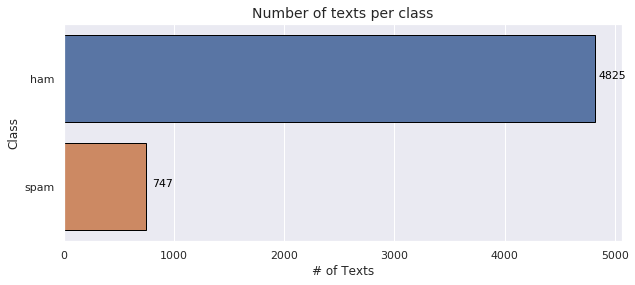

In [0]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(10, 4))

# rendering plot
sns.barplot(x='v2', y='v1', data=class_dist_df, edgecolor='black', orient='h')

# adding chart title
plt.title('Number of texts per class', size=14)

# adding custom labels for axes
plt.ylabel("Class")
plt.xlabel("# of Texts")

# adding labels on data points
for index, row in class_dist_df.iterrows():
    plt.text(row.v2 + 150, index, row.v2, color='black', ha="center", size=11)

## ***Data Preparation***

###***Data Split - Train/Validation***

In [0]:
work_data = raw_data[['v1', 'v2']].copy()
work_data.rename(columns={'v1': 'Label', 'v2': 'Text'}, inplace=True)

text_col = 'Text'
target_col = 'Label'

In [0]:
def data_split(data, save_data=True, load_data=True):
    # Data split part
    train_data, testval_data = train_test_split(data, test_size=0.2, random_state=10, stratify=data[target_col])
    val_data, test_data = train_test_split(testval_data, test_size=0.5, random_state=10, stratify=testval_data[target_col])

    # Setting variables
    file_contents = [train_data, val_data, test_data]
    file_names = ['train_data.csv', 'val_data.csv', 'test_data.csv']

    # Reseting indices on data
    for contents in file_contents:
        contents.reset_index(drop=True, inplace=True)

    # Saving data to csv files
    if save_data:
        for name, contents in zip(file_names, file_contents):
            contents.to_csv(path_or_buf=DATA_DIR/name, index=False, header=True)
    
    # Loading data from csv files
    if load_data:
        for name, contents in zip(file_names, file_contents):
            contents = pd.read_csv(DATA_DIR/name, low_memory=False)
    
    return train_data, test_data, val_data

In [0]:
train_data, test_data, val_data = data_split(work_data)

In [0]:
# Checking the shapes of splited data
[x.shape for x in (train_data, val_data, test_data)]

[(4457, 2), (557, 2), (558, 2)]

In [0]:
train_data.head()

,Label,Text
0,ham,Hey pple...$700 or $900 for 5 nights...Excelle...
1,ham,"Sorry, I can't help you on this."
2,ham,Aiyah e rain like quite big leh. If drizzling ...
3,ham,Plz note: if anyone calling from a mobile Co. ...
4,ham,"Dont worry, 1 day very big lambu ji vl come..t..."


### ***Data Preprocessing***

In [0]:
cat_cols = ['Label']

In [0]:
def cats_fit_transform(df, cat_cols):
    df = df.copy()
    cat_features_map = {}
    df[cat_cols] = df[cat_cols].astype('category')
    for cat_col in cat_cols:
        cat_features_map[cat_col] = dict(enumerate(df[cat_col].cat.categories))
        df[cat_col] = df[cat_col].cat.codes
    return df, cat_features_map

In [0]:
def cats_transform(df, cat_features_map):
    df = df.copy()
    for cat_col in cat_features_map:
        df[cat_col] = df[cat_col].map(
            {value: key for key, value in cat_features_map[cat_col].items()}
        )
        df[cat_col].fillna(value=0, inplace=True)
        df[cat_col] = df[cat_col].astype(int)
    return df

In [0]:
train_data, cat_features_map = cats_fit_transform(train_data, cat_cols)

In [0]:
train_data.head()

,Label,Text
0,0,Hey pple...$700 or $900 for 5 nights...Excelle...
1,0,"Sorry, I can't help you on this."
2,0,Aiyah e rain like quite big leh. If drizzling ...
3,0,Plz note: if anyone calling from a mobile Co. ...
4,0,"Dont worry, 1 day very big lambu ji vl come..t..."


In [0]:
train_data.iloc[4372]

Label      0
Text     :) 
Name: 4372, dtype: object

In [0]:
train_data = train_data.drop([4372])

In [0]:
train_data.iloc[4372]

Label                                                    0
Text     Sorry completely forgot * will pop em round th...
Name: 4373, dtype: object

In [0]:
print(cat_features_map)

{'Label': {0: 'ham', 1: 'spam'}}


In [0]:
classes = list(cat_features_map.get('Label').values())
print(classes)

['ham', 'spam']


In [0]:
# Saving feature mapping for categorical columns into the file
with open(MODEL_DIR/'cat_features_map.pkl', 'wb') as f:
    pickle.dump(cat_features_map, f, pickle.HIGHEST_PROTOCOL)

In [0]:
# Loading feature mapping for categorical columns from the file
with open(MODEL_DIR/'cat_features_map.pkl', 'rb') as f:
    cat_features_map = pickle.load(f)

In [0]:
print(cat_features_map)

{'Label': {0: 'ham', 1: 'spam'}}


In [0]:
val_data = cats_transform(val_data, cat_features_map)

In [0]:
val_data.head()

,Label,Text
0,0,"Customer place, i wil cal u sir."
1,0,Hi ....My engagement has been fixd on &lt;#&g...
2,0,Studying. But i.ll be free next weekend.
3,0,How come?
4,0,What is the plural of the noun research?


In [0]:
val_data.iloc[146]

Label      0
Text     645
Name: 146, dtype: object

In [0]:
val_data = val_data.drop([146])

In [0]:
val_data.iloc[146]

Label                                                    0
Text     If you can make it any time tonight or wheneve...
Name: 147, dtype: object

### ***Dataset Creation***

In [0]:
class_weights = dict(
    enumerate(
        compute_class_weight("balanced", np.unique(train_data[target_col]), train_data[target_col])
    )
)

In [0]:
class_weights

{0: 0.5775012960082945, 1: 3.725752508361204}

In [0]:
def make_dataset(data):
    return tf.data.Dataset.from_tensor_slices((data[text_col].values, data[target_col].values))

In [0]:
train_ds = make_dataset(train_data)
val_ds = make_dataset(val_data)

In [0]:
for x, y in train_ds.take(1):
    print(x)
    print(y)

tf.Tensor(b'Hey pple...$700 or $900 for 5 nights...Excellent location wif breakfast hamper!!!', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int8)


In [0]:
BATCH_SIZE = 32

In [0]:
def preprocess_batch(x, y, max_length=100):
    x = tf.strings.regex_replace(x, rb"<br\s*/?>", b" ")
    x = tf.strings.regex_replace(x, b"[^A-Za-z]", b" ")
    x = tf.strings.split(x)
    x = x.to_tensor(default_value=b"<pad>")
    paddings = tf.constant([[0, 0], [0, max_length]])
    x = tf.pad(x, paddings, constant_values=b"<pad>")
    x = x[:, :max_length]
    return x, y

In [0]:
for x, y in train_ds.batch(BATCH_SIZE).map(preprocess_batch).take(1):
    print(x.shape)
    print(y.shape)
    print(x[7])
    print(y[7])

(32, 100)
(32,)
tf.Tensor(
[b'Have' b'you' b'bookedthe' b'hut' b'And' b'also' b'your' b'time' b'off'
 b'How' b'are' b'you' b'by' b'the' b'way' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>'], shape=(100,), dtype=string)
tf.Tensor(0, shape=(), dtype=int8)


In [0]:
def make_vocabulary(dataset):
    vocabulary = collections.Counter()
    for x, _ in dataset.batch(BATCH_SIZE).map(preprocess_batch):
        for review in x:
            vocabulary.update(review.numpy().tolist())
    return vocabulary

In [0]:
vocabulary = make_vocabulary(train_ds)

In [0]:
vocabulary.most_common()[:10]

[(b'<pad>', 376282),
 (b'to', 1692),
 (b'I', 1644),
 (b'you', 1531),
 (b'a', 1078),
 (b'the', 945),
 (b'i', 811),
 (b'and', 709),
 (b'in', 679),
 (b'u', 649)]

In [0]:
VOCABULARY_SIZE = min(len(vocabulary), 10000)
VOCABULARY_SIZE

8646

In [0]:
word_to_id = {word: index for index, word in enumerate(vocabulary)}

In [0]:
for word in b"This movie is about AI".split():
    print(word_to_id.get(word) or 'Not available')

932
2293
98
1283
Not available


In [0]:
vocabulary = [word for word, count in vocabulary.most_common()]

In [0]:
words = tf.constant(vocabulary)

In [0]:
word_ids = tf.range(len(vocabulary), dtype=tf.int64)

In [0]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

In [0]:
n_oov_buckets = VOCABULARY_SIZE // 10
n_oov_buckets

864

In [0]:
table = tf.lookup.StaticVocabularyTable(vocab_init, n_oov_buckets)

In [0]:
table.lookup(tf.constant([b"This movie is about AI".split()]))

<tf.Tensor: id=18394, shape=(1, 5), dtype=int64, numpy=array([[ 176,  577,   10,   80, 8838]])>

In [0]:
def encode_words(x, y):
    return table.lookup(x), y

In [0]:
def encode_categories(x, y):
    return table.lookup(x), y

In [0]:
train_dataset = (
    train_ds.repeat()
    .batch(BATCH_SIZE, drop_remainder=True)
    .map(preprocess_batch)
    .map(encode_words)
    .prefetch(1)
)

In [0]:
val_dataset = (
    val_ds.batch(BATCH_SIZE, drop_remainder=True)
    .map(preprocess_batch)
    .map(encode_words)
)

In [0]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(32, 100)
(32,)
tf.Tensor(
[ 131 1770   28   12 1539 1329 4201  503 4202 4203    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)
tf.Tensor(0, shape=(), dtype=int8)


In [0]:
for x, y in val_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(32, 100)
(32,)
tf.Tensor(
[ 748  221    6  872 3429    9  873    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


In [0]:
train_dataset_steps = len(train_data) // BATCH_SIZE
val_dataset_steps = len(val_data) // BATCH_SIZE

## ***Exploring Different Model Architectures***

### ***Utilities***

In [0]:
def plot_history(history, contains, skip=0):
    _, ax = plt.subplots(1, len(contains), figsize=(20, 5))

    df = pd.DataFrame(history.history)
    for idx, item in enumerate(contains):
        ax[idx].plot(df[list(df.filter(regex=item))].iloc[skip:])
        ax[idx].set_title(item)

In [0]:
def model_predict(model, dataset, step):
    preds = model.predict(dataset, steps=step)
    labels = np.concatenate([
        y.numpy() for _, y in dataset.take(step)
    ])
    return preds, labels

In [0]:
# Evaluating models
def model_evaluate(labels, preds, n_classes):
    
    # Proccessing predictions
    if n_classes > 2:
        preds = preds.argmax(axis=1)
    else:
        preds = preds > 0.5

    # Evaluating model
    model_prec = precision_score(labels, preds, average='weighted')
    model_accu = accuracy_score(labels, preds)
    model_f1 = f1_score(labels, preds, average='macro')
    
    return model_prec, model_accu, model_f1

In [0]:
def save_nn_model(model, architecture_path, weights_path):
    model.save_weights(weights_path)
    with open(architecture_path, "w") as f:
        f.write(model.to_json())

In [0]:
def load_nn_model(architecture_path, weights_path):
    with open(architecture_path, "r") as f:
        model = keras.models.model_from_json(f.read())
    model.load_weights(weights_path)
    return model

In [0]:
callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.3),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
]

In [0]:
# Preparing to capture models & metrics
model_metrics = pd.DataFrame(columns=['Precision', 'Accuracy', 'F1 score', 'Error'])

### ***RNN Model - Bidirectional LSTM***

In [0]:
def make_lstm_model(
    n_categories,
    embedding_size,
    lstm_size,
    lstm_dropout,
    dropout,
    l1,
    l2,
):
    input_layer = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: keras.backend.not_equal(inputs, 0))(input_layer)
    embedding_layer = keras.layers.Embedding(VOCABULARY_SIZE + n_oov_buckets, embedding_size)(input_layer)

    lstm1_layer = keras.layers.Bidirectional(
        keras.layers.LSTM(lstm_size, dropout=lstm_dropout, return_sequences=True)
    )(embedding_layer, mask=mask)

    lstm2_layer = keras.layers.Bidirectional(
        keras.layers.LSTM(lstm_size, dropout=lstm_dropout, return_sequences=True)
    )(lstm1_layer, mask=mask)

    max_pool_layer = keras.layers.GlobalMaxPool1D()(lstm2_layer)
    batch_norm_layer = keras.layers.BatchNormalization()(max_pool_layer)
    dropout_layer = keras.layers.Dropout(dropout)(batch_norm_layer)

    output_layer = keras.layers.Dense(
        n_categories,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.sigmoid,
    )(dropout_layer)

    return keras.Model(inputs=input_layer, outputs=output_layer)

In [0]:
model = make_lstm_model(
    n_categories=n_classes-1,
    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.4,
    dropout=0.5,
    l1=1e-4,
    l2=1e-6,
)

In [0]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.binary_accuracy,
    ],
)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     608640      input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 128)    66048       embedding[0][0]                  
______________________________________________________________________________________________

In [0]:
history = model.fit(
    x=train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    validation_steps=val_dataset_steps,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Train for 139 steps, validate for 17 steps
Epoch 1/20
139/139 [==============================] - 27s 193ms/step - loss: 0.4547 - binary_accuracy: 0.8161 - val_loss: 0.4060 - val_binary_accuracy: 0.9743
Epoch 2/20
139/139 [==============================] - 6s 42ms/step - loss: 0.1097 - binary_accuracy: 0.9807 - val_loss: 0.1637 - val_binary_accuracy: 0.9688
Epoch 3/20
139/139 [==============================] - 6s 41ms/step - loss: 0.0744 - binary_accuracy: 0.9867 - val_loss: 0.0927 - val_binary_accuracy: 0.9798
Epoch 4/20
139/139 [==============================] - 6s 42ms/step - loss: 0.0488 - binary_accuracy: 0.9919 - val_loss: 0.0967 - val_binary_accuracy: 0.9779
Epoch 5/20
139/139 [==============================] - 6s 42ms/step - loss: 0.0355 - binary_accuracy: 0.9942 - val_loss: 0.0497 - val_binary_accuracy: 0.9890
Epoch 6/20
139/139 [==============================] - 6s 40ms/step - loss: 0.0256 - binary_accuracy: 0.9962 - val_loss: 0.0576 - val_binary_accuracy: 0.9853
Epoch 7/20
13

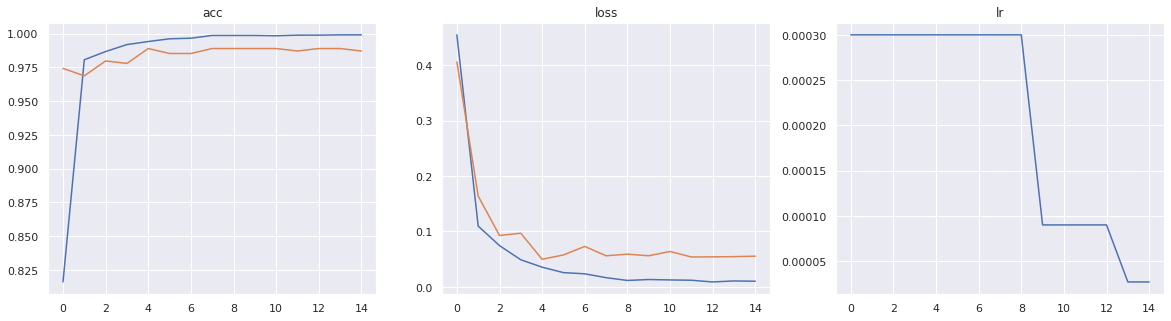

In [0]:
plot_history(history, ['acc', 'loss', 'lr'])

In [0]:
model.evaluate(val_dataset, steps=val_dataset_steps)

17/17 [==============================] - 0s 14ms/step - loss: 0.0497 - binary_accuracy: 0.9890


[0.04966165908776662, 0.9889706]

In [0]:
model_name = 'RNN_LSTM_BiDir'
architecture_path = str(Path(MODEL_DIR/f'{model_name}_weights.h5'))
weights_path = str(Path(MODEL_DIR/f'{model_name}_arch.json'))

In [0]:
save_nn_model(model, architecture_path, weights_path)

In [0]:
del model

In [0]:
loaded_model = load_nn_model(architecture_path, weights_path)

In [0]:
val_predictions, val_labels = model_predict(loaded_model, val_dataset, step=val_dataset_steps)

Precision score: 98.91%
Accuracy score: 98.90%
F1 score: 97.51%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       472
           1       1.00      0.92      0.96        72

    accuracy                           0.99       544
   macro avg       0.99      0.96      0.98       544
weighted avg       0.99      0.99      0.99       544



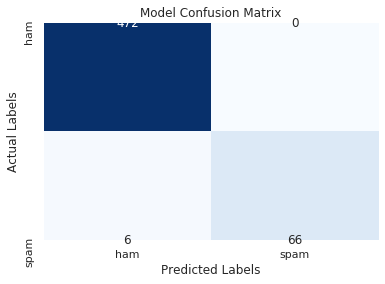

In [0]:
model_report(val_labels, val_predictions, n_classes, classes, all_metrics=True)

In [0]:
model_name = 'RNN - LSTM Bidirectional'
model_prec, model_accu, model_f1 = model_evaluate(val_labels, val_predictions, n_classes)
model_metrics.loc[model_name, 'Precision'] = model_prec
model_metrics.loc[model_name, 'Accuracy'] = model_accu
model_metrics.loc[model_name, 'F1 score'] = model_f1
model_metrics.loc[model_name, 'Error'] = 1 - model_f1

In [0]:
del loaded_model

### ***RNN Model - Bidirectional GRU***

In [0]:
def make_gru_model(
    n_categories,
    embedding_size,
    gru_size,
    gru_dropout,
    dropout,
    l1,
    l2,
):
    input_layer = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: keras.backend.not_equal(inputs, 0))(input_layer)
    embedding_layer = keras.layers.Embedding(VOCABULARY_SIZE + n_oov_buckets, embedding_size)(input_layer)

    gru1_layer = keras.layers.Bidirectional(
        keras.layers.GRU(gru_size, dropout=gru_dropout, return_sequences=True)
    )(embedding_layer, mask=mask)

    gru2_layer = keras.layers.Bidirectional(
        keras.layers.GRU(gru_size, dropout=gru_dropout, return_sequences=True)
    )(gru1_layer, mask=mask)

    max_pool_layer = keras.layers.GlobalMaxPool1D()(gru2_layer)
    batch_norm_layer = keras.layers.BatchNormalization()(max_pool_layer)
    dropout_layer = keras.layers.Dropout(dropout)(batch_norm_layer)

    output_layer = keras.layers.Dense(
        n_categories,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.sigmoid,
    )(dropout_layer)

    return keras.Model(inputs=input_layer, outputs=output_layer)

In [0]:
model = make_gru_model(
    n_categories=n_classes-1,
    embedding_size=64,
    gru_size=64,
    gru_dropout=0.4,
    dropout=0.5,
    l1=1e-4,
    l2=1e-6,
)

In [0]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.binary_accuracy,
    ],
)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     608640      input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None)         0           input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, None, 128)    49920       embedding_1[0][0]                
____________________________________________________________________________________________

In [0]:
history = model.fit(
    x=train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    validation_steps=val_dataset_steps,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Train for 139 steps, validate for 17 steps
Epoch 1/20
139/139 [==============================] - 23s 168ms/step - loss: 0.5534 - binary_accuracy: 0.7352 - val_loss: 0.5073 - val_binary_accuracy: 0.8676
Epoch 2/20
139/139 [==============================] - 5s 38ms/step - loss: 0.2644 - binary_accuracy: 0.9308 - val_loss: 0.3168 - val_binary_accuracy: 0.9246
Epoch 3/20
139/139 [==============================] - 5s 38ms/step - loss: 0.0908 - binary_accuracy: 0.9827 - val_loss: 0.1149 - val_binary_accuracy: 0.9779
Epoch 4/20
139/139 [==============================] - 5s 38ms/step - loss: 0.0471 - binary_accuracy: 0.9897 - val_loss: 0.0777 - val_binary_accuracy: 0.9779
Epoch 5/20
139/139 [==============================] - 5s 39ms/step - loss: 0.0344 - binary_accuracy: 0.9942 - val_loss: 0.0637 - val_binary_accuracy: 0.9835
Epoch 6/20
139/139 [==============================] - 5s 39ms/step - loss: 0.0425 - binary_accuracy: 0.9912 - val_loss: 0.1083 - val_binary_accuracy: 0.9724
Epoch 7/20
13

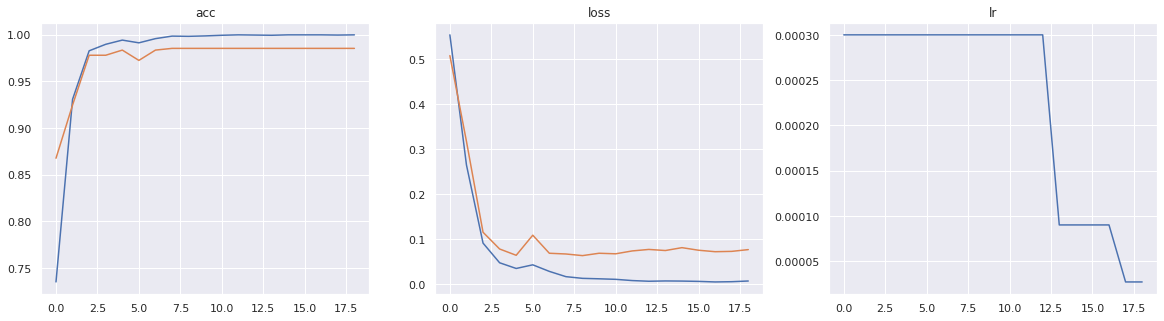

In [0]:
plot_history(history, ['acc', 'loss', 'lr'])

In [0]:
model.evaluate(val_dataset, steps=val_dataset_steps)

17/17 [==============================] - 0s 15ms/step - loss: 0.0629 - binary_accuracy: 0.9853


[0.06294184404096621, 0.9852941]

In [0]:
model_name = 'RNN_GRU_BiDir'
architecture_path = str(Path(MODEL_DIR/f'{model_name}_weights.h5'))
weights_path = str(Path(MODEL_DIR/f'{model_name}_arch.json'))

In [0]:
save_nn_model(model, architecture_path, weights_path)

In [0]:
del model

In [0]:
loaded_model = load_nn_model(architecture_path, weights_path)

In [0]:
val_predictions, val_labels = model_predict(loaded_model, val_dataset, step=val_dataset_steps)

Precision score: 98.55%
Accuracy score: 98.53%
F1 score: 96.64%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       472
           1       1.00      0.89      0.94        72

    accuracy                           0.99       544
   macro avg       0.99      0.94      0.97       544
weighted avg       0.99      0.99      0.98       544



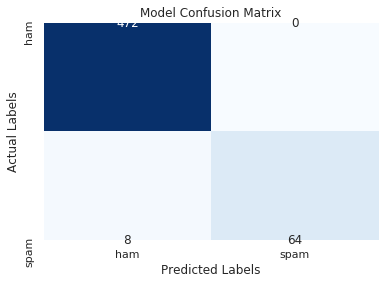

In [0]:
model_report(val_labels, val_predictions, n_classes, classes, all_metrics=True)

In [0]:
model_name = 'RNN - GRU Bidirectional'
model_prec, model_accu, model_f1 = model_evaluate(val_labels, val_predictions, n_classes)
model_metrics.loc[model_name, 'Precision'] = model_prec
model_metrics.loc[model_name, 'Accuracy'] = model_accu
model_metrics.loc[model_name, 'F1 score'] = model_f1
model_metrics.loc[model_name, 'Error'] = 1 - model_f1

In [0]:
del loaded_model

### ***CNN Model - 1D Convolutions***

In [0]:
def make_cnn_model(
    n_categories,
    embedding_size,
    conv_size,
    kernel_size,
    dropout,
    l1,
    l2,
    stride=2,
):
    input_layer = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: keras.backend.not_equal(inputs, 0))(input_layer)
    embedding_layer = keras.layers.Embedding(VOCABULARY_SIZE + n_oov_buckets, embedding_size)(input_layer)

    cnn1_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(embedding_layer)
    cnn1_dropout = keras.layers.Dropout(dropout)(cnn1_layer)

    cnn2_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(cnn1_dropout)
    cnn2_dropout = keras.layers.Dropout(dropout)(cnn2_layer)

    max_pool_layer = keras.layers.GlobalMaxPool1D()(cnn2_dropout)
    batch_norm_layer = keras.layers.BatchNormalization()(max_pool_layer)
    dropout_layer = keras.layers.Dropout(dropout)(batch_norm_layer)

    output_layer = keras.layers.Dense(
        n_categories,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.sigmoid,
    )(dropout_layer)

    return keras.Model(inputs=input_layer, outputs=output_layer)

In [0]:
model = make_cnn_model(
    n_categories=n_classes-1,
    embedding_size=64,
    conv_size=64,
    kernel_size=3,
    dropout=0.5,
    l1=1e-4,
    l2=1e-6,
)

In [0]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.binary_accuracy,
    ],
)

In [0]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 64)          608640    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0   

In [0]:
history = model.fit(
    x=train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    validation_steps=val_dataset_steps,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Train for 139 steps, validate for 17 steps
Epoch 1/20
139/139 [==============================] - 3s 23ms/step - loss: 0.8173 - binary_accuracy: 0.5717 - val_loss: 0.5386 - val_binary_accuracy: 0.8676
Epoch 2/20
139/139 [==============================] - 2s 13ms/step - loss: 0.6281 - binary_accuracy: 0.6895 - val_loss: 0.4169 - val_binary_accuracy: 0.8676
Epoch 3/20
139/139 [==============================] - 2s 13ms/step - loss: 0.4787 - binary_accuracy: 0.7918 - val_loss: 0.3340 - val_binary_accuracy: 0.8676
Epoch 4/20
139/139 [==============================] - 2s 13ms/step - loss: 0.3647 - binary_accuracy: 0.8651 - val_loss: 0.2821 - val_binary_accuracy: 0.8676
Epoch 5/20
139/139 [==============================] - 2s 13ms/step - loss: 0.2685 - binary_accuracy: 0.9128 - val_loss: 0.2366 - val_binary_accuracy: 0.8860
Epoch 6/20
139/139 [==============================] - 2s 13ms/step - loss: 0.1923 - binary_accuracy: 0.9472 - val_loss: 0.1904 - val_binary_accuracy: 0.9173
Epoch 7/20
139/

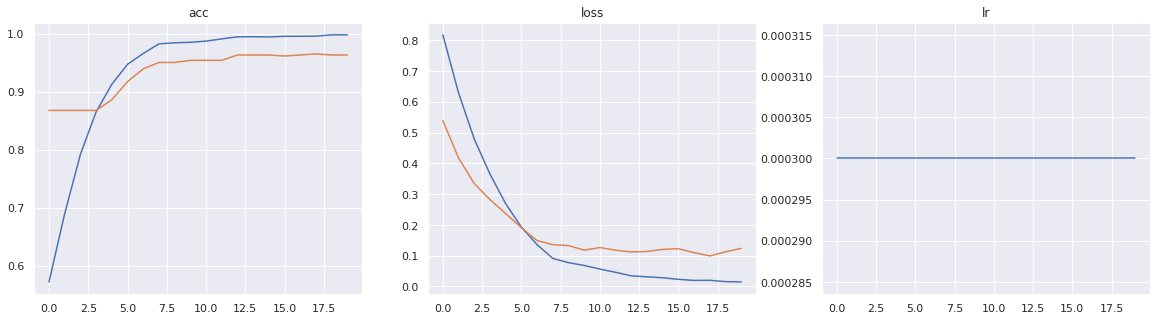

In [0]:
plot_history(history, ['acc', 'loss', 'lr'])

In [0]:
model.evaluate(val_dataset, steps=val_dataset_steps)

17/17 [==============================] - 0s 5ms/step - loss: 0.1236 - binary_accuracy: 0.9632


[0.12360799029086005, 0.9632353]

In [0]:
model_name = 'CNN_1D_Conv'
architecture_path = str(Path(MODEL_DIR/f'{model_name}_weights.h5'))
weights_path = str(Path(MODEL_DIR/f'{model_name}_arch.json'))

In [0]:
save_nn_model(model, architecture_path, weights_path)

In [0]:
del model

In [0]:
loaded_model = load_nn_model(architecture_path, weights_path)

In [0]:
val_predictions, val_labels = model_predict(loaded_model, val_dataset, step=val_dataset_steps)

Precision score: 96.47%
Accuracy score: 96.32%
F1 score: 90.90%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       472
           1       1.00      0.72      0.84        72

    accuracy                           0.96       544
   macro avg       0.98      0.86      0.91       544
weighted avg       0.96      0.96      0.96       544



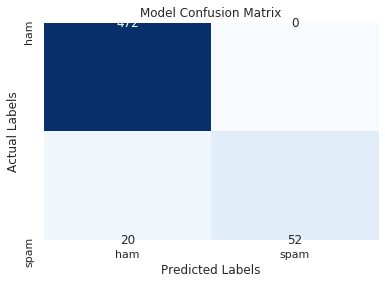

In [0]:
model_report(val_labels, val_predictions, n_classes, classes, all_metrics=True)

In [0]:
model_name = 'CNN - 1D Convolutional'
model_prec, model_accu, model_f1 = model_evaluate(val_labels, val_predictions, n_classes)
model_metrics.loc[model_name, 'Precision'] = model_prec
model_metrics.loc[model_name, 'Accuracy'] = model_accu
model_metrics.loc[model_name, 'F1 score'] = model_f1
model_metrics.loc[model_name, 'Error'] = 1 - model_f1

In [0]:
del loaded_model

### ***Mix Model - 1D Convs & LSTM***

In [0]:
def make_mix_model(
    n_categories,
    embedding_size,
    lstm_size,
    lstm_dropout,
    conv_size,
    kernel_size,
    dropout,
    l1,
    l2,
    stride=2,
):
    input_layer = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: keras.backend.not_equal(inputs, 0))(input_layer)
    embedding_layer = keras.layers.Embedding(VOCABULARY_SIZE + n_oov_buckets, embedding_size)(input_layer)

    lstm_layer = keras.layers.Bidirectional(
        keras.layers.LSTM(lstm_size, dropout=lstm_dropout, return_sequences=True)
    )(embedding_layer, mask=mask)

    cnn_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(lstm_layer)
    cnn_dropout = keras.layers.Dropout(dropout)(cnn_layer)

    max_pool_layer = keras.layers.GlobalMaxPool1D()(cnn_dropout)
    batch_norm_layer = keras.layers.BatchNormalization()(max_pool_layer)
    dropout_layer = keras.layers.Dropout(dropout)(batch_norm_layer)

    output_layer = keras.layers.Dense(
        n_categories,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.sigmoid,
    )(dropout_layer)

    return keras.Model(inputs=input_layer, outputs=output_layer)

In [0]:
model = make_mix_model(
    n_categories=n_classes-1,
    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.4,
    conv_size=64,
    kernel_size=3,
    dropout=0.5,
    l1=1e-4,
    l2=1e-6,
)

In [0]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.binary_accuracy,
    ],
)

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     608640      input_4[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None)         0           input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, None, 128)    66048       embedding_3[0][0]                
____________________________________________________________________________________________

In [0]:
history = model.fit(
    x=train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=val_dataset,
    validation_steps=val_dataset_steps,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Train for 139 steps, validate for 17 steps
Epoch 1/20
139/139 [==============================] - 16s 116ms/step - loss: 0.5650 - binary_accuracy: 0.7194 - val_loss: 0.5567 - val_binary_accuracy: 0.8676
Epoch 2/20
139/139 [==============================] - 4s 31ms/step - loss: 0.2696 - binary_accuracy: 0.9222 - val_loss: 0.3562 - val_binary_accuracy: 0.9706
Epoch 3/20
139/139 [==============================] - 4s 30ms/step - loss: 0.1211 - binary_accuracy: 0.9831 - val_loss: 0.1615 - val_binary_accuracy: 0.9779
Epoch 4/20
139/139 [==============================] - 4s 31ms/step - loss: 0.0757 - binary_accuracy: 0.9894 - val_loss: 0.1001 - val_binary_accuracy: 0.9798
Epoch 5/20
139/139 [==============================] - 5s 33ms/step - loss: 0.0490 - binary_accuracy: 0.9937 - val_loss: 0.0696 - val_binary_accuracy: 0.9835
Epoch 6/20
139/139 [==============================] - 4s 32ms/step - loss: 0.0373 - binary_accuracy: 0.9960 - val_loss: 0.0686 - val_binary_accuracy: 0.9816
Epoch 7/20
13

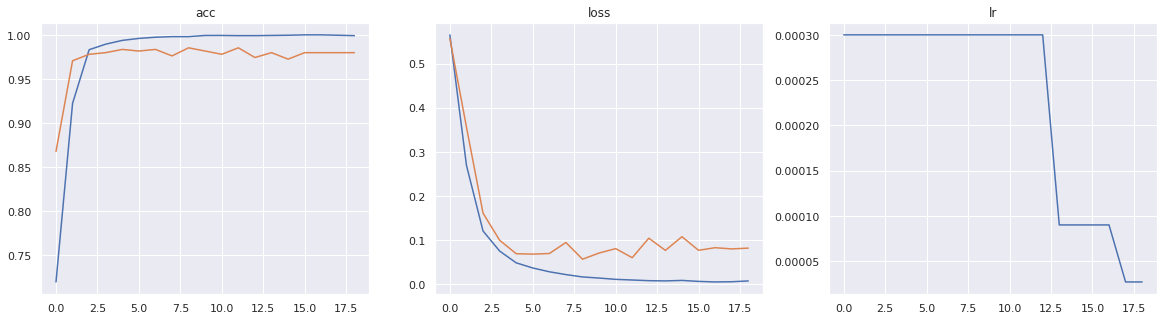

In [0]:
plot_history(history, ['acc', 'loss', 'lr'])

In [0]:
model.evaluate(val_dataset, steps=val_dataset_steps)

17/17 [==============================] - 0s 11ms/step - loss: 0.0572 - binary_accuracy: 0.9853


[0.05716516833533259, 0.9852941]

In [0]:
model_name = 'Mix_LSTM_1D_Conv'
architecture_path = str(Path(MODEL_DIR/f'{model_name}_weights.h5'))
weights_path = str(Path(MODEL_DIR/f'{model_name}_arch.json'))

In [0]:
save_nn_model(model, architecture_path, weights_path)

In [0]:
del model

In [0]:
loaded_model = load_nn_model(architecture_path, weights_path)

In [0]:
val_predictions, val_labels = model_predict(loaded_model, val_dataset, step=val_dataset_steps)

Precision score: 98.53%
Accuracy score: 98.53%
F1 score: 96.68%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       472
           1       0.98      0.90      0.94        72

    accuracy                           0.99       544
   macro avg       0.99      0.95      0.97       544
weighted avg       0.99      0.99      0.99       544



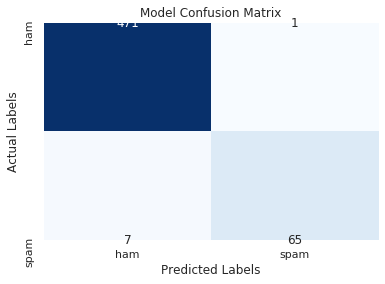

In [0]:
model_report(val_labels, val_predictions, n_classes, classes, all_metrics=True)

In [0]:
model_name = 'Mix - LSTM & 1D Convs'
model_prec, model_accu, model_f1 = model_evaluate(val_labels, val_predictions, n_classes)
model_metrics.loc[model_name, 'Precision'] = model_prec
model_metrics.loc[model_name, 'Accuracy'] = model_accu
model_metrics.loc[model_name, 'F1 score'] = model_f1
model_metrics.loc[model_name, 'Error'] = 1 - model_f1

In [0]:
del loaded_model

### ***Results***

In [0]:
model_metrics.sort_values(by='F1 score', ascending=False)

,Precision,Accuracy,F1 score,Error
RNN - LSTM Bidirectional,0.989109,0.988971,0.975103,0.024897
Mix - LSTM & 1D Convs,0.985289,0.985294,0.966804,0.033196
RNN - GRU Bidirectional,0.985539,0.985294,0.966387,0.0336134
CNN - 1D Convolutional,0.96473,0.963235,0.908981,0.0910186


In [0]:
results_df = model_metrics.copy().sort_values(by='Error').reset_index()

In [0]:
results_df = results_df.rename(columns={'index':'Model'})[['Model','Error']]

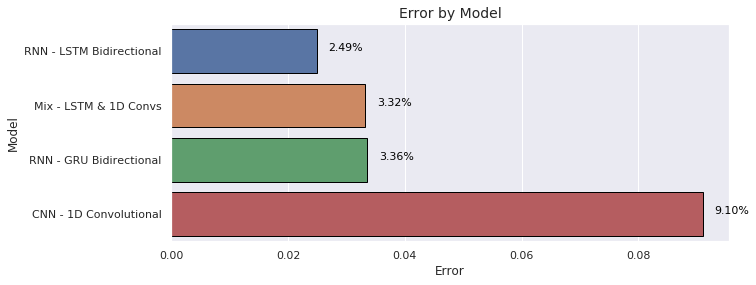

In [0]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(10, 4))

# rendering plot
sns.barplot(x='Error', y='Model', data=results_df, edgecolor='black', orient='h')

# adding chart title
plt.title('Error by Model', size=14)

# adding custom labels for axes
plt.ylabel("Model")
plt.xlabel("Error")

# adding labels on data points
for index, row in results_df.iterrows():
    plt.text(row.Error + 0.005, index, f'{row.Error:.2%}', color='black', ha="center", size=11)

## ***Final Model***

In [0]:
valtrain_data = pd.concat([train_data, val_data], ignore_index=True)

valtrain_ds = make_dataset(valtrain_data)
test_ds = make_dataset(test_data)

In [0]:
print([x.shape for x in (train_data, val_data, valtrain_data)])

[(4456, 2), (556, 2), (5012, 2)]


In [0]:
valtrain_dataset = (
    valtrain_ds.repeat()
    .batch(BATCH_SIZE, drop_remainder=True)
    .map(preprocess_batch)
    .map(encode_words)
    .prefetch(1)
)

In [0]:
test_dataset = (
    test_ds.batch(BATCH_SIZE, drop_remainder=True)
    .map(preprocess_batch)
    .map(encode_words)
)

In [0]:
valtrain_dataset_steps = len(valtrain_data) // BATCH_SIZE
test_dataset_steps = len(test_data) // BATCH_SIZE

In [0]:
model = make_lstm_model(
    n_categories=n_classes-1,
    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.4,
    dropout=0.5,
    l1=1e-4,
    l2=1e-6,
)

In [0]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.binary_accuracy,
    ],
)

In [0]:
def scheduler(epoch):
    lr = 3e-4
    if epoch < 10:
        return lr
    elif epoch < 14:
        return lr * 0.3
    else:
        return lr * 0.09

In [0]:
total_epochs = 5
callbacks=[
    keras.callbacks.LearningRateScheduler(scheduler)
]

In [0]:
history = model.fit(
    x=valtrain_dataset,
    steps_per_epoch=valtrain_dataset_steps,
    epochs=total_epochs,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Train for 156 steps
Epoch 1/5
156/156 [==============================] - 7s 45ms/step - loss: 0.1095 - binary_accuracy: 0.9774
Epoch 2/5
  1/156 [..............................] - ETA: 2s

CancelledError: ignored

In [0]:
model.evaluate(test_dataset, steps=test_dataset_steps)

In [0]:
model_name = 'Final_Model'
architecture_path = str(Path(MODEL_DIR/f'{model_name}_weights.h5'))
weights_path = str(Path(MODEL_DIR/f'{model_name}_arch.json'))

In [0]:
save_nn_model(model, architecture_path, weights_path)

In [0]:
del model

In [0]:
loaded_model = load_nn_model(architecture_path, weights_path)

In [0]:
test_predictions, test_labels = model_predict(loaded_model, test_dataset, step=test_dataset_steps)

In [0]:
model_report(test_labels, test_predictions, n_classes, classes, all_metrics=True)